Building configuration for pair: ['GS' 'BLK']

------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     368  2022-10-06
Val       221  2023-05-10
Test      148  2023-08-24


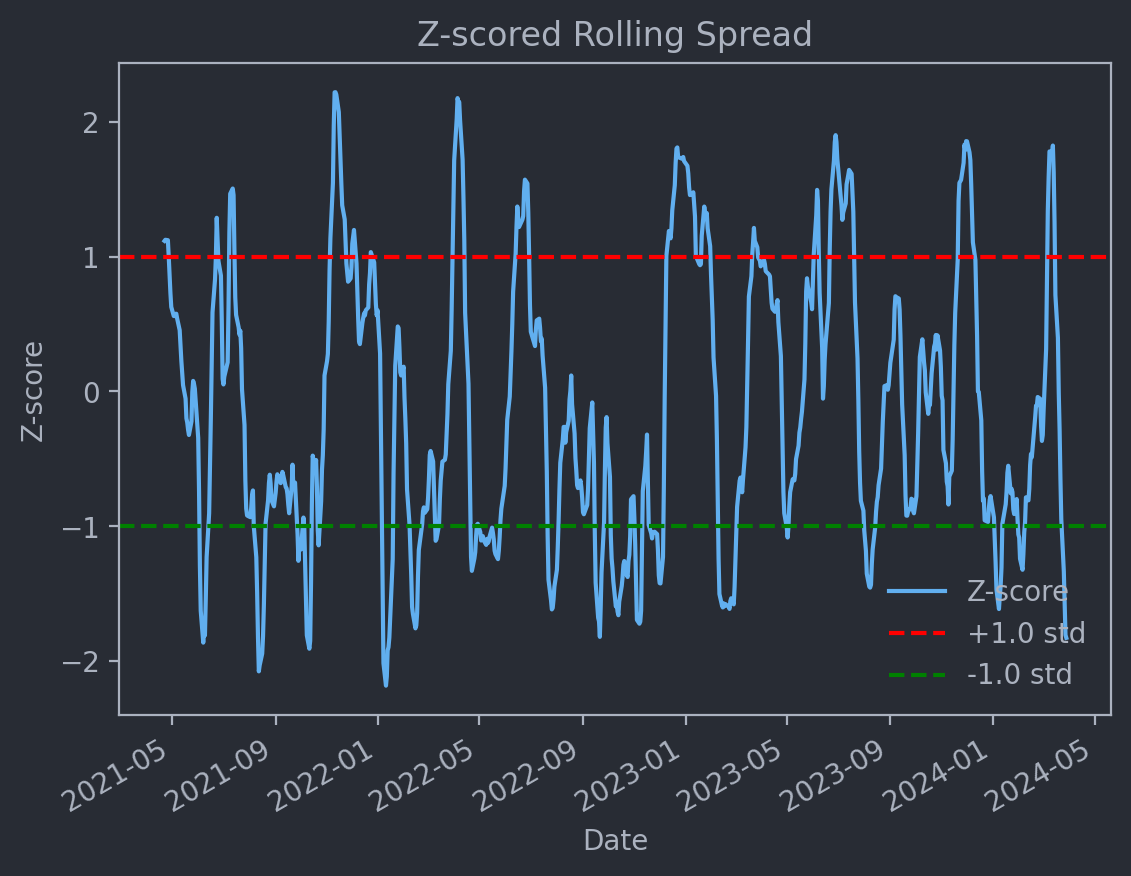


GradientBoostingRegressor

R2: 0.83, MAE: 0.34, MAPE: 355.32%


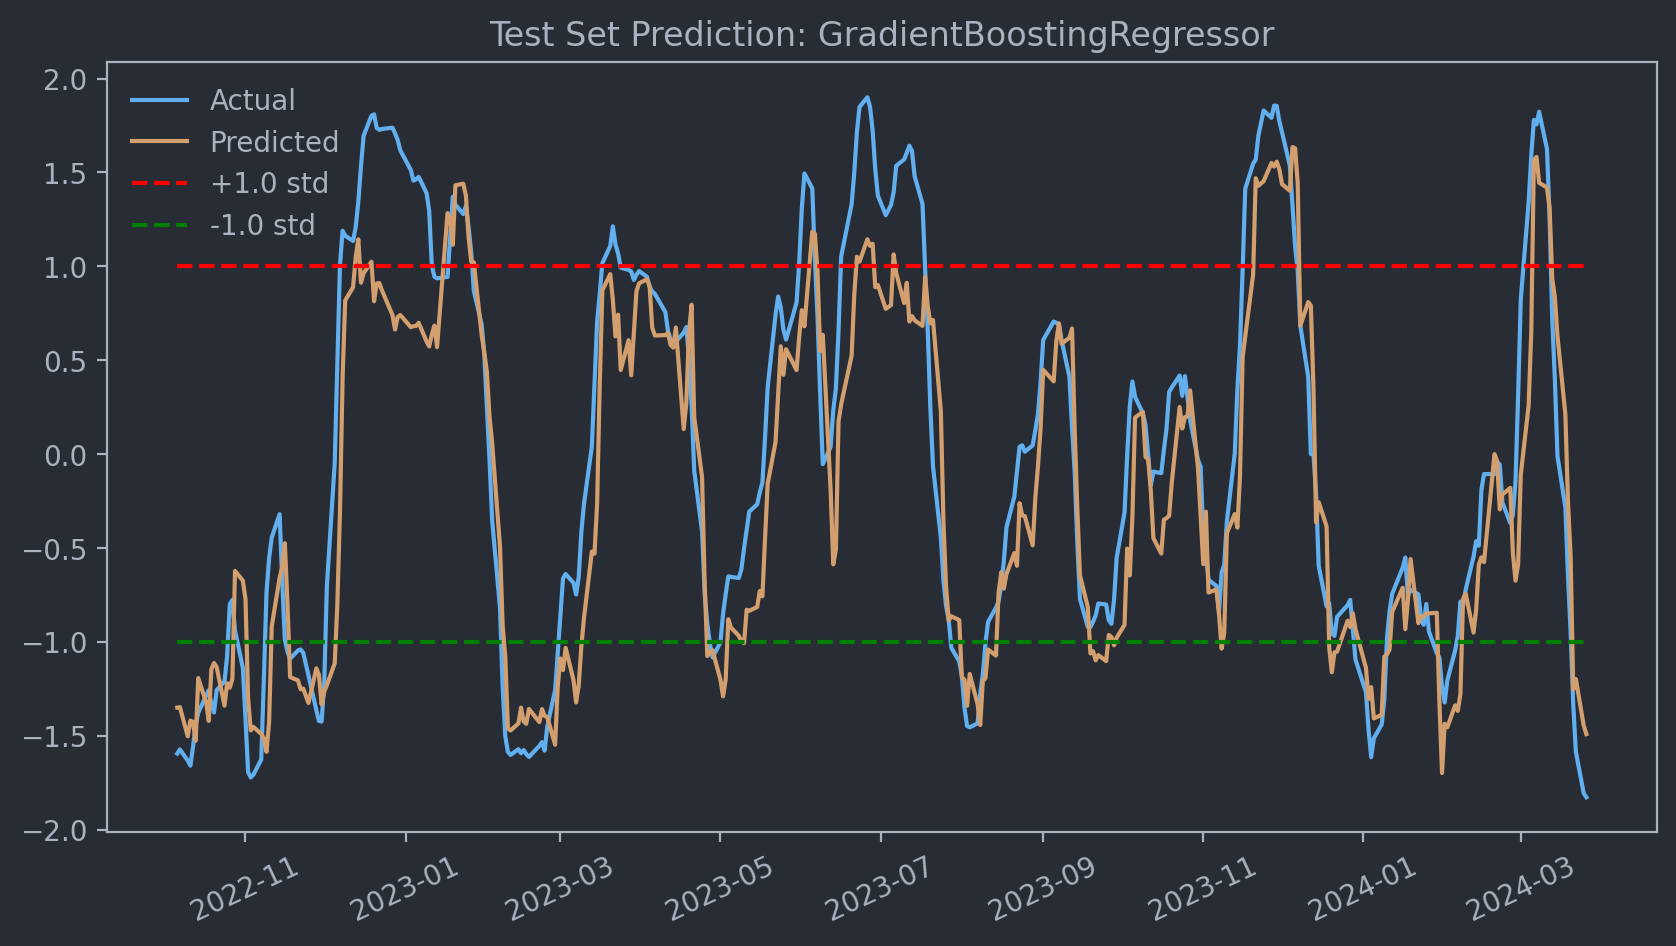

In [1]:
from typing import DefaultDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import warnings
import glob
warnings.filterwarnings('ignore')
plt.style.use('custom_onedark')




def norm_plot(df):
    df = df.copy()
    df = (df - df.mean()) / df.std()
    return df


def plot_zscore(pair_df, zscore_col='zscore_spread'):
    pair_df['zscore_spread'].plot(title='Z-scored Rolling Spread')
    plt.xlabel('Date')
    plt.ylabel('Z-score')
    # plt.axhline(0, color='black', label='Mean')
    plt.axhline(1.0, color='red', linestyle='--', label='+1.0 std')
    plt.axhline(-1.0, color='green', linestyle='--', label='-1.0 std')
    plt.legend(['Z-score', '+1.0 std', '-1.0 std'])
    plt.show()

def add_moving_averages(df, moving_averages, columns):
    df = df.copy()
    for ma in moving_averages:
        for col in columns:
            new_col = f'{col}_ma{ma}'
            df[new_col] = df[col].rolling(window=ma).mean()
    # ffill na
    df.fillna(method='ffill', inplace=True)
    return df

from tabulate import tabulate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

# If window param is set, then spread is calculated on a rolling basis
def get_spread(S1, S2, window=None):
    s1_ols = sm.add_constant(S1)
    if window:
        spread_model = sm.regression.rolling.RollingOLS(S2, s1_ols, window=window).fit()
    else:
        spread_model = sm.OLS(S2, s1_ols).fit()
    beta = spread_model.params[S1.name]
    spread = S2 - beta * S1
    return spread


def create_dataset(data, look_back, target_col="spread_close", split_sizes=[0.5, 0.3, 0.2], drop_cols: list = []):
    data = data.copy().dropna()
    y = data[target_col]
    y_shifted = y.shift(-look_back)

    data["target"] = y_shifted
    data = data.dropna().drop(drop_cols, axis=1)
    train_size = int(len(data) * split_sizes[0])
    val_size = int(len(data) * split_sizes[1])
    test_size = len(data) - train_size - val_size

    print("\n------Dataset Information------")
    print(tabulate([
            ["Train", train_size, data.index[train_size].date()],
            ["Val", val_size, data.index[-val_size].date()],
            ["Test", test_size, data.index[-test_size].date()]],
        ["Set", "Size", "Date Cutoff"]))

    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size : train_size + val_size]
    test_data = data.iloc[-test_size:]
    return train_data, val_data, test_data


def prepare_dataset(train_data, val_data, test_data):
    X_train, y_train = train_data.drop(columns=["target"]), train_data["target"]
    X_val, y_val = val_data.drop(columns=["target"]), val_data["target"]
    X_test, y_test = test_data.drop(columns=["target"]), test_data["target"]

    return X_train, y_train, X_val, y_val, X_test, y_test



data_dir = '../../../data/'
price_history_dir = data_dir + 'price_history/'
sentiment_dir = data_dir + 'sentiments/'
ti_dir = data_dir + 'technical_indicators/'

# Load Ticker Pairs
tickers_list = [file.split('/')[-1].strip('.csv') for file in glob.glob(price_history_dir + '*.csv')]
pairs_df = pd.read_csv(data_dir + 'ranked_pairs_snp.csv')
pairs = pairs_df[['ticker_0', 'ticker_1']].values
unique_pairs = pairs_df[['ticker_0', 'ticker_1']].drop_duplicates('ticker_0', keep='first').drop_duplicates('ticker_1', keep='first')

# Load Ticker History, Sentiment, and Technical Indicators
class TickerData:
    def __init__(self, ticker):
        self.ticker = ticker
        self.history = pd.read_csv(price_history_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.sentiment = pd.read_csv(sentiment_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.ti = pd.read_csv(ti_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
    def __repr__(self):
        return repr(self.history['Adj Close'])

class DATA:
    pass

data = {}
for ticker in tickers_list:
    setattr(DATA, ticker, TickerData(ticker))
    data[ticker] = TickerData(ticker)

# Functions for data processing
def join_sentiment(data, pair, add_sentiment_ma=DefaultDict()):
    pair_sentiment_df = pd.merge(data[pair[0]].sentiment, data[pair[1]].sentiment, left_index=True, right_index=True, suffixes=("_S1", "_S2"))
    if add_sentiment_ma.get('bool'):
        if not add_sentiment_ma.get('windows'):
            add_sentiment_ma['windows'] = [5, 10, 20, 40, 80]
        pair_sentiment_df = add_moving_averages(pair_sentiment_df, add_sentiment_ma.get('windows'), columns=pair_sentiment_df.columns)
    return pair_sentiment_df

def join_technical_indicators(data, pair):
    return pd.merge(data[pair[0]].ti, data[pair[1]].ti, left_index=True, right_index=True, suffixes=("_S1", "_S2"))

# If window param is set, then spread is calculated on a rolling basis
# Adjusted function to fit on the training set only
def get_spread(S1_train, S2_train, S1_all, S2_all, window=None):
    s1_ols_train = sm.add_constant(S1_train)
    s1_ols_all = sm.add_constant(S1_all)

    if window:
        spread_model = sm.regression.rolling.RollingOLS(S2_train, s1_ols_train, window=window).fit()
        spread_all = sm.regression.rolling.RollingOLS(S2_all, s1_ols_all, window=window).fit()
    else:
        spread_model = sm.OLS(S2_train, s1_ols_train).fit()
        beta_train = spread_model.params[S1_train.name]
        spread_all = S2_all - beta_train * S1_all

    return spread_all

# Adjust the calculate_spread function to use train data
def calculate_spread(pair_df, spread_window, ma_high, ma_low, train_end_idx):
    spread = get_spread(pair_df['Adj Close_S1'][:train_end_idx],
                        pair_df['Adj Close_S2'][:train_end_idx],
                        pair_df['Adj Close_S1'],
                        pair_df['Adj Close_S2'],
                        window=spread_window)
    pair_df['spread'] = spread

    ma_high_values = pair_df.spread.rolling(window=ma_high).mean()
    ma_low_values = pair_df.spread.rolling(window=ma_low).mean()
    std_high = pair_df.spread.rolling(window=ma_high).std()

    moving_zscore = (ma_low_values - ma_high_values) / std_high
    pair_df['zscore_spread'] = moving_zscore
    return pair_df



def setup_dataset(pair_df, look_back, drop_cols, target_col='zscore_spread'):
    train_data, val_data, test_data = create_dataset(pair_df, look_back=look_back, target_col=target_col, drop_cols=drop_cols)
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)
    X_test = pd.concat([X_val, X_test])
    y_test = pd.concat([y_val, y_test])
    return X_train, y_train, X_test, y_test

def calculate_metrics(y_true, y_pred):
    metric_frame = {
        "mape": mean_absolute_percentage_error(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred)
    }
    print(f"\nR2: {metric_frame['r2']:.2f}, MAE: {metric_frame['mae']:.2f}, MAPE: {metric_frame['mape']*100:.2f}%")
    return metric_frame


class Config:
    def __init__(self, pair_df=None, X_train=None, y_train=None, X_test=None, y_test=None, model=None, y_pred=None):
        self.pair_df = pair_df
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = model
        self.y_pred = y_pred

    def update(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)


def build_configuration(config):
    pair = pairs[config['PAIR_IDX']]
    print(f"Building configuration for pair: {pair}")
    pair_sentiment_df = join_sentiment(data, pair, config['ADD_SENTIMENT_MA'])
    pair_ti_df = join_technical_indicators(data, pair)
    pair_df = pd.merge(pair_ti_df, pair_sentiment_df, left_index=True, right_index=True, how="left")
    pair_df = pair_df.loc[:config.get('max_date')] if config.get('max_date') else pair_df

    train_end_idx = int(len(pair_df) * config.get('TRAIN_SPLIT') if config.get('TRAIN_SPLIT') else int(len(pair_df) * 0.5))
    pair_df = calculate_spread(pair_df, config['SPREAD_WINDOW'], config['MA_HIGH'], config['MA_LOW'], train_end_idx).dropna()
    X_train, y_train, X_test, y_test = setup_dataset(pair_df, config['LOOK_BACK'], config['DROP_COLS'])
    plot_zscore(pair_df) if config['Verbose'] else None

    return Config(pair_df=pair_df, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)


def plot_prediction(y_test, y_pred, model_name):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(y_test.index, y_test, label="Actual")
    ax.plot(y_test.index, y_pred, label=f"Predicted ({model_name})")
    ax.hlines(1.0, y_test.index[0], y_test.index[-1], color='red', linestyle='--', label='+1.0 std')
    ax.hlines(-1.0, y_test.index[0], y_test.index[-1], color='green', linestyle='--', label='-1.0 std')
    plt.title(f"Test Set Prediction: {model_name}")
    plt.xticks(rotation=25)
    ax.legend(['Actual', 'Predicted', '+1.0 std', '-1.0 std'])
    plt.show()


def train(model, config, plot=True):
    model.fit(config.X_train, config.y_train)
    config.y_pred = model.predict(config.X_test)
    config.model = model
    model_name = model.__class__.__name__
    print(f"\n{model_name}")
    metrics = calculate_metrics(config.y_test, config.y_pred)
    if plot:
        plot_prediction(config.y_test, config.y_pred, model_name)
    return metrics


current_config =  {
        'PAIR_IDX': 0,
        'ADD_SENTIMENT_MA': {'bool': True, 'windows': [5, 10, 20, 40, 80,]},
        'SPREAD_WINDOW': None,
        'MA_HIGH': 45,
        'MA_LOW': 5,
        'LOOK_BACK': 2,
        'DROP_COLS': [
            # 'zscore_spread', 'spread'
            ],
        # 'DROP_COLS': [],
        'Verbose': 3,
        "target_col": "spread_zscore",
        # 'max_date': '2024-01-01',
    }
config = build_configuration(current_config)

from sklearn.ensemble import GradientBoostingRegressor


model_gbm = GradientBoostingRegressor(n_estimators=100, random_state=42)

metrics = train(model_gbm, config)


In [6]:
import numpy as np

data_backtest = pd.DataFrame()
config.X_test = config.X_test.reset_index()
# data_backtest.index = config.X_test['Date']
data_backtest['Date'] = config.X_test['Date']
data_backtest['S1'] = config.X_test['Adj Close_S1']
data_backtest['S2'] = config.X_test['Adj Close_S2']
data_backtest['z'] = config.y_pred

zscore_threshold = 1
portfolio = data_backtest.iloc[18:24, :].reset_index()

initial_capital = 100000  # Initial capital

# Initialize variables for backtesting
cash = initial_capital
cash_S1 =  initial_capital / 2
cash_S2 =  initial_capital / 2
zscore_upper = 1
zscore_lower = -1

portfolio['cash_S1'] = None
portfolio['cash_S2'] = None
portfolio['position_size_S1'] = None
portfolio['position_size_S2'] = None
num_shares_S1, num_shares_S2 = None, None
trade_S1, trade_S2 = False, False
portfolio.at[0, 'position_size_S1'] = 0 
portfolio.at[0, 'position_size_S2'] = 0 

portfolio['signal_S1'] = np.where(['z'] > zscore_threshold, -1, 1)

position_size_S1 = 0
position_size_S2 = 0

for i in range(len(portfolio)):
    traded_S1, traded_S2 = False, False
    zscore   = portfolio.at[i, 'z']
    price_S1    = portfolio.at[i, 'S1']
    price_S2    = portfolio.at[i, 'S2']


    # Adjust the position based on the z-score
    if zscore > 0:
        # Buy S1, Sell S2
        num_shares_S1 = cash_S1 / price_S1
        cash_S1 -= num_shares_S1 * price_S1
        traded_S1 = True

        if num_shares_S2 is None:
            num_shares_S2 = -cash_S2 / price_S2
        cash_S2 += num_shares_S2 * price_S2 
        traded_S2 = True
        
    elif zscore < 0:
        # Sell S1, Buy S2
        if num_shares_S1 is None:
            num_shares_S1 = -cash_S1 / price_S1
        cash_S1 += num_shares_S1 * price_S1 
        traded_S1 = True

        num_shares_S2 = cash_S2 / price_S2
        cash_S2 -= num_shares_S2 * price_S2 
        traded_S2 = True
        
    # Update the cash
    cash = cash_S1 + cash_S2
    portfolio.at[i, 'cash_S1'] = cash_S1
    portfolio.at[i, 'cash_S2'] = cash_S2
    portfolio.at[i, 'cash'] = cash
    portfolio.at[i, 'num_shares_S1'] = num_shares_S1
    portfolio.at[i, 'num_shares_S2'] = num_shares_S2

    if traded_S1 or traded_S2:
        portfolio.at[i, 'position_size_S1'] = position_size_S1 + num_shares_S1 * price_S1
        portfolio.at[i, 'position_size_S2'] = position_size_S2 + num_shares_S2 * price_S2
    else:
        # portfolio.at[i, 'position_size_S1'] = position_size_S1
        # portfolio.at[i, 'position_size_S2'] = position_size_S2
        position_size_S1 = portfolio.at[i, 'position_size_S1']
        position_size_S2 = portfolio.at[i, 'position_size_S2']
    
portfolio


TypeError: '>' not supported between instances of 'list' and 'int'

In [7]:

import numpy as np

data_backtest = pd.DataFrame()
config = config.X_test.reset_index()
# data_backtest.index = config.X_test['Date']
data_backtest['Date'] = config.X_test['Date']
data_backtest['S1'] = config.X_test['Adj Close_S1']
data_backtest['S2'] = config.X_test['Adj Close_S2']
data_backtest['z'] = config.y_pred


portfolio = data_backtest.iloc[18:24, :].reset_index()

for i in range(1, len(portfolio)):
    traded_S1, traded_S2 = False, False
    zscore   = portfolio.at[i, 'z']
    price_S1    = portfolio.at[i, 'S1']
    price_S2    = portfolio.at[i, 'S2']

    # Adjust the position based on the z-score
    if zscore > zscore_upper:
        # Buy S1, Sell S2
        num_shares_S1 = cash_S1 / price_S1
        cash_S1 -= num_shares_S1 * price_S1
        traded_S1 = True

        if num_shares_S2 is None:
            num_shares_S2 = -cash_S2 / price_S2
        cash_S2 += num_shares_S2 * price_S2 
        traded_S2 = True
        
    elif zscore < zscore_lower:
        # Sell S1, Buy S2
        if num_shares_S1 is None:
            num_shares_S1 = -cash_S1 / price_S1
        cash_S1 += num_shares_S1 * price_S1 
        traded_S1 = True

        num_shares_S2 = cash_S2 / price_S2
        cash_S2 -= num_shares_S2 * price_S2 
        traded_S2 = True

    # If no trade was made, copy the previous row
    if not traded_S1 and not traded_S2:
        portfolio.iloc[i] = portfolio.iloc[i-1]
        continue

    # Update the cash
    cash = cash_S1 + cash_S2
    portfolio.at[i, 'cash_S1'] = cash_S1
    portfolio.at[i, 'cash_S2'] = cash_S2
    portfolio.at[i, 'cash'] = cash
    portfolio.at[i, 'num_shares_S1'] = num_shares_S1
    portfolio.at[i, 'num_shares_S2'] = num_shares_S2

    if traded_S1 or traded_S2:
        portfolio.at[i, 'position_size_S1'] = position_size_S1 + num_shares_S1 * price_S1
        portfolio.at[i, 'position_size_S2'] = position_size_S2 + num_shares_S2 * price_S2
    else:
        portfolio.at[i, 'position_size_S1'] = position_size_S1
        portfolio.at[i, 'position_size_S2'] = position_size_S2
    position_size_S1 = portfolio.at[i, 'position_size_S1']
    position_size_S2 = portfolio.at[i, 'position_size_S2']

ValueError: cannot insert level_0, already exists

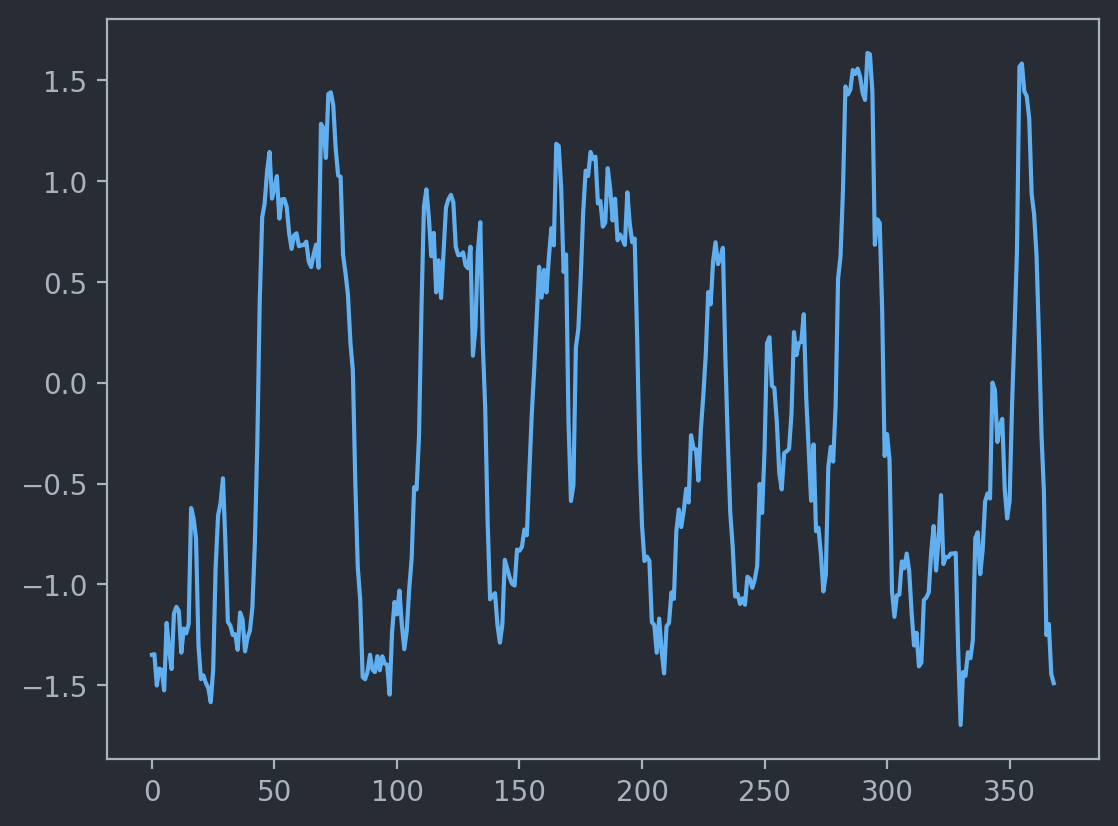

In [8]:
config.y_pred

plt.plot(config.y_pred)

In [9]:
import numpy as np

data_backtest = pd.DataFrame()
data_backtest.index = config.X_test.index
data_backtest['S1'] = config.X_test['Adj Close_S1']
data_backtest['S2'] = config.X_test['Adj Close_S2']
data_backtest['z'] = config.y_pred


# portfolio = data_backtest.iloc[18:24, :].reset_index()
portfolio = data_backtest.iloc[:, :].reset_index()

initial_capital = 100000  # Initial capital

# Initialize variables for backtesting
cash = initial_capital
cash_S1 = initial_capital / 2
cash_S2 = initial_capital / 2
zscore_upper = 1
zscore_lower = -1


portfolio['signal_S1'] = pd.Series(np.where(portfolio['z'] > zscore_upper, -1, np.where(portfolio['z'] < zscore_lower, 1, -1))).diff()
portfolio['signal_S2'] = pd.Series(np.where(portfolio['z'] > zscore_upper, 1, np.where(portfolio['z'] < zscore_lower, -1, 1))).diff()
portfolio['cash_S1'] = None
portfolio['cash_S2'] = None
portfolio['position_size_S1'] = None
portfolio['position_size_S2'] = None
num_shares_S1, num_shares_S2 = None, None
trade_S1, trade_S2 = False, False
portfolio.at[0, 'position_size_S1'] = 0
portfolio.at[0, 'position_size_S2'] = 0

# Initialize positions
portfolio['positions_S1'] = 0
portfolio['positions_S2'] = 0


portfolio['position_S1'] = np.where(portfolio['z'] > zscore_upper, -1, np.where(portfolio['z'] < zscore_lower, 1, -1))
portfolio['position_S2'] = np.where(portfolio['z'] > zscore_upper, 1, np.where(portfolio['z'] < zscore_lower, -1, 1))


for i in range(len(portfolio)):
    traded_S1, traded_S2 = False, False
    zscore = portfolio.at[i, 'z']
    price_S1 = portfolio.at[i, 'S1']
    price_S2 = portfolio.at[i, 'S2']

for i in portfolio.index[1:]:
    print(i)
    # Check if no threshold is met (no signal)
    if portfolio.loc[i, 'signal_S1'] == 0:
        # Fill the entire row with the contents of the previous row
        portfolio.loc[i, 'cash_S1':] = portfolio.loc[i-1, 'cash_S1':]
        # print(f"Signal is 0, copying previous row {i-1}")
        # display(portfolio.loc[i-1])

    # Adjust the position based on the z-score
    if zscore > zscore_upper:
        # Buy S1, Sell S2
        num_shares_S1 = cash_S1 / price_S1
        cash_S1 -= num_shares_S1 * price_S1
        traded_S1 = True

        if num_shares_S2 is None:
            num_shares_S2 = -cash_S2 / price_S2
        cash_S2 += num_shares_S2 * price_S2
        traded_S2 = True

    elif zscore < zscore_lower:
        # Sell S1, Buy S2
        if num_shares_S1 is None:
            num_shares_S1 = -cash_S1 / price_S1
        cash_S1 += num_shares_S1 * price_S1
        traded_S1 = True

        num_shares_S2 = cash_S2 / price_S2
        cash_S2 -= num_shares_S2 * price_S2
        traded_S2 = True

    # Update the cash
    cash = cash_S1 + cash_S2
    portfolio.at[i, 'cash_S1'] = cash_S1
    portfolio.at[i, 'cash_S2'] = cash_S2
    portfolio.at[i, 'cash'] = cash
    portfolio.at[i, 'num_shares_S1'] = num_shares_S1
    portfolio.at[i, 'num_shares_S2'] = num_shares_S2

    if traded_S1 or traded_S2:
        portfolio.at[i, 'position_size_S1'] = position_size_S1 + num_shares_S1 * price_S1
        portfolio.at[i, 'position_size_S2'] = position_size_S2 + num_shares_S2 * price_S2
    else:
        portfolio.at[i, 'position_size_S1'] = position_size_S1
        portfolio.at[i, 'position_size_S2'] = position_size_S2

    position_size_S1 = portfolio.at[i, 'position_size_S1']
    position_size_S2 = portfolio.at[i, 'position_size_S2']

portfolio


1


NameError: name 'position_size_S1' is not defined

In [10]:
import pickle 
with open('config.pkl', 'wb') as f:
    pickle.dump(config, f)

In [11]:
with open('config.pkl', 'rb') as f:
    config = pickle.load(f)

import numpy as np

data_backtest = pd.DataFrame()
# config.X_test = config.X_test.reset_index()
data_backtest.index = config.X_test.index
# data_backtest['Date'] = config.X_test.index
data_backtest['S1'] = config.X_test['Adj Close_S1']
data_backtest['S2'] = config.X_test['Adj Close_S2']
data_backtest['z'] = config.y_pred


# portfolio = data_backtest.iloc[18:24, :].reset_index()
portfolio = data_backtest.iloc[:, :].reset_index()


initial_capital = 100000  # Initial capital

# Initialize variables for backtesting
cash = initial_capital
cash_S1 = initial_capital / 2
cash_S2 = initial_capital / 2
zscore_upper = 1
zscore_lower = -1

portfolio['signal_S1'] = pd.Series(np.where(portfolio['z'] > zscore_upper, -1, np.where(portfolio['z'] < zscore_lower, 1, -1))).diff()
portfolio['signal_S2'] = pd.Series(np.where(portfolio['z'] > zscore_upper, 1, np.where(portfolio['z'] < zscore_lower, -1, 1))).diff()

portfolio['cash_S1'] = None
portfolio['cash_S2'] = None
portfolio['cash_S1'].iloc[0] = cash_S1
portfolio['cash_S2'].iloc[0] = cash_S2


portfolio['position_size_S1'] = None
portfolio['position_size_S2'] = None
num_shares_S1, num_shares_S2 = None, None
trade_S1, trade_S2 = False, False
portfolio.at[0, 'position_size_S1'] = 0
portfolio.at[0, 'position_size_S2'] = 0

# Initialize positions
# portfolio['positions_S1'] = 0
# portfolio['positions_S2'] = 0


portfolio['position_S1'] = np.where(portfolio['z'] > zscore_upper, -1, np.where(portfolio['z'] < zscore_lower, 1, -1))
portfolio['position_S2'] = np.where(portfolio['z'] > zscore_upper, 1, np.where(portfolio['z'] < zscore_lower, -1, 1))


portfolio

for i in portfolio.index[1:]:
    print(i)
    # Check if no threshold is met (no signal)
    if portfolio.loc[i, 'signal_S1'] == 0:
        # Fill the entire row with the contents of the previous row
        portfolio.loc[i, 'cash_S1':] = portfolio.loc[i-1, 'cash_S1':]
        # print(f"Signal is 0, copying previous row {i-1}")
        # display(portfolio.loc[i-1])

    if portfolio.loc[i].signal_S1 > 0:
        #long S1 and short S2
        positions_to_buy_S1 = cash_S1 / price_S1
        portfolio.loc[i, 'positions_size_S1'] = positions_to_buy_S1
        portfolio.loc[i, 'position_S1'] = positions_to_buy_S1 * price_S1
        cash_S1 -= positions_to_buy_S1 * price_S1

        positions_to_sell_S2 = cash_S2 / price_S2
        portfolio.loc[i, 'positions_size_S2'] = positions_to_sell_S2
        portfolio.loc[i, 'position_S2'] = positions_to_sell_S2 * price_S2
        cash_S2 += positions_to_sell_S2 * price_S2

    elif portfolio.loc[i].signal_S1 < 0:
        # short S1 and long S2
        positions_to_sell_S1 = cash_S1 / price_S1
        portfolio.loc[i, 'positions_size_S1'] = positions_to_sell_S1
        portfolio.loc[i, 'position_S1'] = positions_to_sell_S1 * price_S1
        cash_S1 += positions_to_sell_S1 * price_S1

        positions_to_buy_S2 = cash_S2 / price_S2
        portfolio.loc[i, 'positions_size_S2'] = positions_to_buy_S2
        portfolio.loc[i, 'position_S2'] = positions_to_buy_S2 * price_S2
        cash_S2 -= positions_to_buy_S2 * price_S2

    portfolio.loc[i, 'cash_S1'] = cash_S1
    portfolio.loc[i, 'cash_S2'] = cash_S2

portfolio
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


,index,S1,S2,z,signal_S1,signal_S2,cash_S1,cash_S2,position_size_S1,position_size_S2,position_S1,position_S2,positions_size_S1,positions_size_S2
0,0,304.67,571.61,-1.349420,NaN,NaN,50000.0,50000.0,0,0,1,-1,NaN,NaN
1,1,301.08,550.40,-1.346556,0.0,0.0,50000.0,50000.0,0,0,1,-1,NaN,NaN
2,2,300.54,545.54,-1.501935,0.0,0.0,50000.0,50000.0,0,0,1,-1,NaN,NaN
3,3,294.21,531.14,-1.418144,0.0,0.0,50000.0,50000.0,0,0,1,-1,NaN,NaN
4,4,295.31,531.10,-1.425404,0.0,0.0,50000.0,50000.0,0,0,1,-1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,364,396.47,817.89,-0.543413,0.0,0.0,0.0,0.0,None,None,0,0,0.0,0.0
365,365,413.71,842.06,-1.251465,2.0,-2.0,0.0,0.0,None,None,0,0,0.0,0.0
366,366,406.82,824.83,-1.197028,0.0,0.0,0.0,0.0,None,None,0,0,0.0,0.0
367,367,404.94,816.21,-1.445789,0.0,0.0,0.0,0.0,None,None,0,0,0.0,0.0


In [16]:
with open('config.pkl', 'rb') as f:
    config = pickle.load(f)

data_backtest = pd.DataFrame()
# config.X_test = config.X_test.reset_index()
data_backtest.index = config.X_test.index
data_backtest['Date'] = config.X_test.index
data_backtest['S1'] = config.X_test['Adj Close_S1']
data_backtest['S2'] = config.X_test['Adj Close_S2']
data_backtest['z'] = config.y_pred
portfolio = data_backtest.iloc[14:22, :].reset_index()
# portfolio = data_backtest.iloc[:, :].reset_index()
initial_capital = 100000  # Initial capital

# Initialize variables for backtesting
cash = initial_capital
cash_S1 = initial_capital / 2
cash_S2 = initial_capital / 2
zscore_upper = 1
zscore_lower = -1


portfolio['signal_S1'] = pd.Series(np.where(portfolio['z'] > zscore_upper, -1, np.where(portfolio['z'] < zscore_lower, 1, -1))).diff()
portfolio['signal_S2'] = pd.Series(np.where(portfolio['z'] > zscore_upper, 1, np.where(portfolio['z'] < zscore_lower, -1, 1))).diff()

portfolio = portfolio.dropna()

portfolio['cash_S1'] = None
portfolio['cash_S2'] = None
portfolio['cash_S1'].iloc[0] = cash_S1
portfolio['cash_S2'].iloc[0] = cash_S2

# Initialize variables for backtesting
cash = initial_capital
cash_S1 = initial_capital / 2
cash_S2 = initial_capital / 2
zscore_upper = 1
zscore_lower = -1

portfolio['cash_S1'] = None
portfolio['cash_S2'] = None
portfolio['cash_S1'].iloc[0] = cash_S1
portfolio['cash_S2'].iloc[0] = cash_S2

portfolio['holdings_S1'] = 0
portfolio['holdings_S2'] = 0

portfolio['position_size_S1'] = 0
portfolio['position_size_S2'] = 0
num_shares_S1, num_shares_S2 = None, None
trade_S1, trade_S2 = False, False
portfolio.at[0, 'position_size_S1'] = 0
portfolio.at[0, 'position_size_S2'] = 0

# calculate if signal is == 0 then we are not trading
# if signal is > 0 then we are buying S1 and selling S2
# if signal is < 0 then we are selling S1 and buying S2

# we set position size equal to the cash we have divided by the price of the stock
# we set the position equal to the position size times the price of the stock
# we update the cash for each of the stocks respectively

for i in portfolio.index[1:]:
    print(i)
    # Check if no threshold is met (no signal)
    if portfolio.loc[i, 'signal_S1'] == 0:
        # Fill the entire row with the contents of the previous row
        portfolio.loc[i, 'cash_S1':] = portfolio.loc[i-1, 'cash_S1':]
        print(f"Signal is 0, copying previous row {i-1}")
        display(portfolio.loc[i-1])
    # Adjust the position based on the z-score

    if portfolio.loc[i].signal_S1 > 0:
        #long S1 and short S2
        positions_to_buy_S1 = cash_S1 / price_S1
        portfolio.loc[i, 'position_size_S1'] = positions_to_buy_S1
        portfolio.loc[i, 'position_S1'] = positions_to_buy_S1 * price_S1
        cash_S1 -= positions_to_buy_S1 * price_S1
        portfolio.loc[i, 'cash_S1'] = cash_S1
        portfolio.loc[i, 'holdings_S1'] = positions_to_buy_S1 * price_S1

        positions_to_sell_S2 = cash_S2 / price_S2
        portfolio.loc[i, 'position_size_S2'] = positions_to_sell_S2
        portfolio.loc[i, 'position_S2'] = positions_to_sell_S2 * price_S2
        cash_S2 += positions_to_sell_S2 * price_S2
        portfolio.loc[i, 'cash_S2'] = cash_S2
        portfolio.loc[i, 'holdings_S2'] = positions_to_sell_S2 * price_S2

    elif portfolio.loc[i].signal_S1 < 0:
        # short S1 and long S2
        positions_to_sell_S1 = cash_S1 / price_S1
        print(positions_to_sell_S1)
        portfolio.loc[i, 'position_size_S1'] = positions_to_sell_S1
        portfolio.loc[i, 'position_S1'] = positions_to_sell_S1 * price_S1
        cash_S1 += positions_to_sell_S1 * price_S1
        portfolio.loc[i, 'cash_S1'] = cash_S1
        portfolio.loc[i, 'holdings_S1'] = positions_to_sell_S1 * price_S1

        positions_to_buy_S2 = cash_S2 / price_S2
        portfolio.loc[i, 'position_size_S2'] = positions_to_buy_S2
        portfolio.loc[i, 'position_S2'] = positions_to_buy_S2 * price_S2
        cash_S2 -= positions_to_buy_S2 * price_S2
        portfolio.loc[i, 'cash_S2'] = cash_S2
        portfolio.loc[i, 'holdings_S2'] = positions_to_buy_S2 * price_S2

portfolio.head(10).to_clipboard()
portfolio

2
123.0981338322911
3
Signal is 0, copying previous row 2


index                     16.0
Date                      16.0
S1                      341.82
S2                      663.75
z                    -0.621504
signal_S1                 -2.0
signal_S2                  2.0
cash_S1               100000.0
cash_S2                    0.0
holdings_S1            50000.0
holdings_S2            50000.0
position_size_S1    123.098134
position_size_S2     60.960741
position_S1            50000.0
position_S2            50000.0
Name: 2, dtype: object

4
Signal is 0, copying previous row 3


index                     17.0
Date                      17.0
S1                      344.51
S2                      645.91
z                    -0.673346
signal_S1                  0.0
signal_S2                  0.0
cash_S1               100000.0
cash_S2                    0.0
holdings_S1            50000.0
holdings_S2            50000.0
position_size_S1    123.098134
position_size_S2     60.960741
position_S1            50000.0
position_S2            50000.0
Name: 3, dtype: object

5
6
Signal is 0, copying previous row 5


index                     19.0
Date                      19.0
S1                      349.79
S2                      638.81
z                    -1.300484
signal_S1                  2.0
signal_S2                 -2.0
cash_S1                    0.0
cash_S2                    0.0
holdings_S1           100000.0
holdings_S2                0.0
position_size_S1    246.196268
position_size_S2           0.0
position_S1           100000.0
position_S2                0.0
Name: 5, dtype: object

7
Signal is 0, copying previous row 6


index                     20.0
Date                      20.0
S1                      348.87
S2                      633.81
z                    -1.470468
signal_S1                  0.0
signal_S2                  0.0
cash_S1                    0.0
cash_S2                    0.0
holdings_S1           100000.0
holdings_S2                0.0
position_size_S1    246.196268
position_size_S2           0.0
position_S1           100000.0
position_S2                0.0
Name: 6, dtype: object

0


,index,Date,S1,S2,z,signal_S1,signal_S2,cash_S1,cash_S2,holdings_S1,holdings_S2,position_size_S1,position_size_S2,position_S1,position_S2
1,15.0,15.0,337.18,648.98,-1.197141,0.0,0.0,50000.0,50000.0,0.0,0.0,0.000000,0.000000,NaN,NaN
2,16.0,16.0,341.82,663.75,-0.621504,-2.0,2.0,100000.0,0.0,50000.0,50000.0,123.098134,60.960741,50000.0,50000.0
3,17.0,17.0,344.51,645.91,-0.673346,0.0,0.0,100000.0,0.0,50000.0,50000.0,123.098134,60.960741,50000.0,50000.0
4,18.0,18.0,348.58,652.00,-0.771223,0.0,0.0,100000.0,0.0,50000.0,50000.0,123.098134,60.960741,50000.0,50000.0
5,19.0,19.0,349.79,638.81,-1.300484,2.0,-2.0,0.0,0.0,100000.0,0.0,246.196268,0.000000,100000.0,0.0
6,20.0,20.0,348.87,633.81,-1.470468,0.0,0.0,0.0,0.0,100000.0,0.0,246.196268,0.000000,100000.0,0.0
7,21.0,21.0,357.91,656.15,-1.451858,0.0,0.0,0.0,0.0,100000.0,0.0,246.196268,0.000000,100000.0,0.0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN


In [17]:
import pandas as pd
import numpy as np

# Assume the 'data_backtest' DataFrame is already created and populated as in the provided snippet
with open('config.pkl', 'rb') as f:
    config = pickle.load(f)

data_backtest = pd.DataFrame()
data_backtest.index = config.X_test.index
data_backtest['S1'] = config.X_test['Adj Close_S1']
data_backtest['S2'] = config.X_test['Adj Close_S2']
data_backtest['z'] = config.y_pred
data_backtest = data_backtest.iloc[:, :].reset_index()
portfolio = data_backtest.iloc[:, :].reset_index()
# Set threshold and initial capital


threshold = 1
initial_capital = 100000

# Define trading signals
data_backtest['long_spread'] = data_backtest['z'] < -threshold
data_backtest['short_spread'] = data_backtest['z'] > threshold

# Initialize holdings and PnL
data_backtest['position_S1'] = 0
data_backtest['position_S2'] = 0
data_backtest['cash'] = initial_capital
data_backtest['pnl'] = 0

# Iterate over each day to calculate positions and PnL
for i in range(1, len(data_backtest)):
    if data_backtest.iloc[i]['long_spread']:
        data_backtest.at[i, 'position_S1'] = 1  # Buy S1
        data_backtest.at[i, 'position_S2'] = -1  # Short S2
    elif data_backtest.iloc[i]['short_spread']:
        data_backtest.at[i, 'position_S1'] = -1  # Short S1
        data_backtest.at[i, 'position_S2'] = 1  # Buy S2

    # Calculate the cash based on positions and current prices
    data_backtest.at[i, 'cash'] = data_backtest.iloc[i-1]['cash'] \
        - data_backtest.iloc[i]['position_S1'] * data_backtest.iloc[i]['S1'] \
        - data_backtest.iloc[i]['position_S2'] * data_backtest.iloc[i]['S2']

    # Calculate the PnL
    data_backtest.at[i, 'pnl'] = data_backtest.iloc[i]['cash'] \
        + data_backtest.iloc[i]['position_S1'] * data_backtest.iloc[i]['S1'] \
        + data_backtest.iloc[i]['position_S2'] * data_backtest.iloc[i]['S2']

# Display the results
print(data_backtest[['Date', 'position_S1', 'position_S2', 'cash', 'pnl']])


KeyError: "['Date'] not in index"

In [21]:
import pandas as pd

with open('config.pkl', 'rb') as f:
    config = pickle.load(f)

data_backtest = pd.DataFrame()
data_backtest.index = config.X_test.index
data_backtest['S1'] = config.X_test['Adj Close_S1']
data_backtest['S2'] = config.X_test['Adj Close_S2']
data_backtest['z'] = config.y_pred
data_backtest = data_backtest.iloc[:, :].reset_index()
portfolio = data_backtest.iloc[:, :].reset_index()

# Set threshold and initial capital
threshold = 1
initial_capital = 100000

# Define trading signals
data_backtest['long_spread'] = data_backtest['z'] < -threshold
data_backtest['short_spread'] = data_backtest['z'] > threshold

# Initialize holdings and PnL
data_backtest['position_S1'] = 0
data_backtest['position_S2'] = 0
data_backtest['holdings_S1'] = 0
data_backtest['holdings_S2'] = 0
data_backtest['cash'] = initial_capital
data_backtest['pnl'] = 0

# Iterate over each day to calculate positions, holdings in cash, and PnL
for i in range(1, len(data_backtest)):
    if data_backtest.iloc[i]['long_spread']:
        data_backtest.at[i, 'position_S1'] = 1  # Buy S1
        data_backtest.at[i, 'position_S2'] = -1  # Short S2
    elif data_backtest.iloc[i]['short_spread']:
        data_backtest.at[i, 'position_S1'] = -1  # Short S1
        data_backtest.at[i, 'position_S2'] = 1  # Buy S2

    # Update holdings in cash for S1 and S2
    data_backtest.at[i, 'holdings_S1'] = data_backtest.iloc[i]['position_S1'] * data_backtest.iloc[i]['S1']
    data_backtest.at[i, 'holdings_S2'] = data_backtest.iloc[i]['position_S2'] * data_backtest.iloc[i]['S2']

    # Calculate cash balance after trades
    data_backtest.at[i, 'cash'] = data_backtest.iloc[i - 1]['cash'] \
        - data_backtest.iloc[i]['holdings_S1'] \
        - data_backtest.iloc[i]['holdings_S2']

    # Calculate the PnL (cash + holdings)
    data_backtest.at[i, 'pnl'] = data_backtest.iloc[i]['cash'] \
        + data_backtest.iloc[i]['holdings_S1'] \
        + data_backtest.iloc[i]['holdings_S2']

# Display the results
display(data_backtest[[ 'position_S1', 'position_S2', 'holdings_S1', 'holdings_S2', 'cash', 'pnl']])
data_backtest

,position_S1,position_S2,holdings_S1,holdings_S2,cash,pnl
0,0,0,0.00,0.00,100000.00,0.00
1,1,-1,301.08,-550.40,100249.32,100000.00
2,1,-1,300.54,-545.54,100494.32,100249.32
3,1,-1,294.21,-531.14,100731.25,100494.32
4,1,-1,295.31,-531.10,100967.04,100731.25
...,...,...,...,...,...,...
364,0,0,0.00,0.00,118318.15,118318.15
365,1,-1,413.71,-842.06,118746.50,118318.15
366,1,-1,406.82,-824.83,119164.51,118746.50
367,1,-1,404.94,-816.21,119575.78,119164.51


,index,S1,S2,z,long_spread,short_spread,position_S1,position_S2,holdings_S1,holdings_S2,cash,pnl
0,0,304.67,571.61,-1.349420,True,False,0,0,0.00,0.00,100000.00,0.00
1,1,301.08,550.40,-1.346556,True,False,1,-1,301.08,-550.40,100249.32,100000.00
2,2,300.54,545.54,-1.501935,True,False,1,-1,300.54,-545.54,100494.32,100249.32
3,3,294.21,531.14,-1.418144,True,False,1,-1,294.21,-531.14,100731.25,100494.32
4,4,295.31,531.10,-1.425404,True,False,1,-1,295.31,-531.10,100967.04,100731.25
...,...,...,...,...,...,...,...,...,...,...,...,...
364,364,396.47,817.89,-0.543413,False,False,0,0,0.00,0.00,118318.15,118318.15
365,365,413.71,842.06,-1.251465,True,False,1,-1,413.71,-842.06,118746.50,118318.15
366,366,406.82,824.83,-1.197028,True,False,1,-1,406.82,-824.83,119164.51,118746.50
367,367,404.94,816.21,-1.445789,True,False,1,-1,404.94,-816.21,119575.78,119164.51


## w hedge ratio

,position_S1,position_S2,holdings_S1,holdings_S2,cash,pnl
1,1,0.000000,301.08,0.000000,99698.920000,100000.000000
2,1,-5.908078,300.54,-3223.092840,102621.472840,99698.920000
3,1,-6.156391,294.21,-3269.905598,105597.168438,102621.472840
4,1,-3.548079,295.31,-1884.384641,107186.243079,105597.168438
5,1,-3.648021,307.07,-2064.889283,108944.062361,107186.243079
...,...,...,...,...,...,...
364,0,0.000000,0.00,0.000000,167609.574936,167609.574936
365,1,-2.029844,413.71,-1709.250826,168905.115762,167609.574936
366,1,-2.029556,406.82,-1674.038999,170172.334761,168905.115762
367,1,-2.028575,404.94,-1655.742859,171423.137620,170172.334761


,index,S1,S2,z,long_spread,short_spread,position_S1,position_S2,holdings_S1,holdings_S2,cash,pnl,hedge_ratio,net_exposure
1,1,301.08,550.40,-1.346556,True,False,1,0.000000,301.08,0.000000,99698.920000,100000.000000,0.000000,301.080000
2,2,300.54,545.54,-1.501935,True,False,1,-5.908078,300.54,-3223.092840,102621.472840,99698.920000,5.908078,-2922.552840
3,3,294.21,531.14,-1.418144,True,False,1,-6.156391,294.21,-3269.905598,105597.168438,102621.472840,6.156391,-2975.695598
4,4,295.31,531.10,-1.425404,True,False,1,-3.548079,295.31,-1884.384641,107186.243079,105597.168438,3.548079,-1589.074641
5,5,307.07,566.03,-1.525954,True,False,1,-3.648021,307.07,-2064.889283,108944.062361,107186.243079,3.648021,-1757.819283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,364,396.47,817.89,-0.543413,False,False,0,0.000000,0.00,0.000000,167609.574936,167609.574936,2.027934,0.000000
365,365,413.71,842.06,-1.251465,True,False,1,-2.029844,413.71,-1709.250826,168905.115762,167609.574936,2.029844,-1295.540826
366,366,406.82,824.83,-1.197028,True,False,1,-2.029556,406.82,-1674.038999,170172.334761,168905.115762,2.029556,-1267.218999
367,367,404.94,816.21,-1.445789,True,False,1,-2.028575,404.94,-1655.742859,171423.137620,170172.334761,2.028575,-1250.802859


<Axes: >

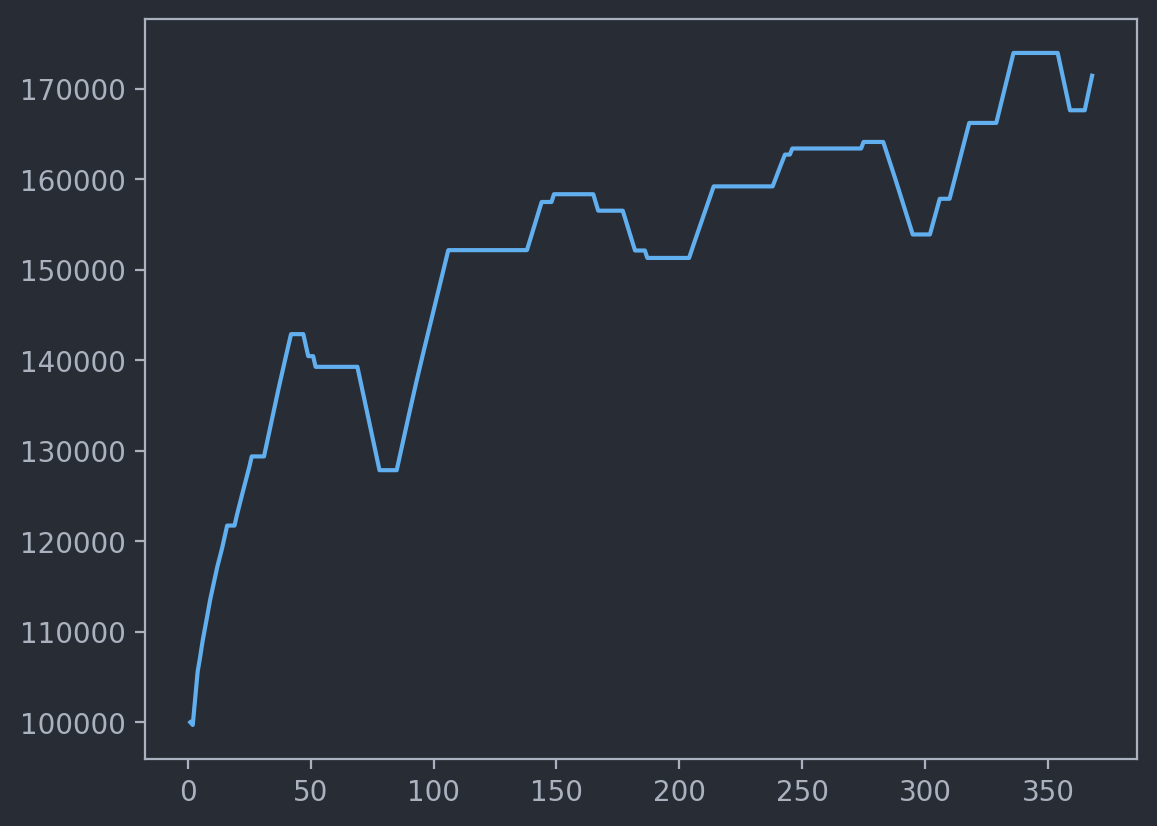

In [34]:
import pandas as pd
from sklearn.linear_model import BayesianRidge

with open('config.pkl', 'rb') as f:
    config = pickle.load(f)

data_backtest = pd.DataFrame()
data_backtest.index = config.X_test.index
data_backtest['S1'] = config.X_test['Adj Close_S1']
data_backtest['S2'] = config.X_test['Adj Close_S2']
data_backtest['z'] = config.y_pred
data_backtest = data_backtest.iloc[:, :].reset_index()
portfolio = data_backtest.iloc[:, :].reset_index()



# Set threshold, initial capital, and hedge ratio
threshold = 1
initial_capital = 100000
hedge_ratio = 1  # Adjust the hedge ratio as desired

# Initialize Bayesian model for calc of dynamic hedge ratio
model = BayesianRidge()


# Define trading signals
data_backtest['long_spread'] = data_backtest['z'] < -threshold
data_backtest['short_spread'] = data_backtest['z'] > threshold

# Initialize holdings and PnL
data_backtest['position_S1'] = 0
data_backtest['position_S2'] = 0
data_backtest['holdings_S1'] = 0
data_backtest['holdings_S2'] = 0
data_backtest['cash'] = initial_capital
data_backtest['pnl'] = 0


def update_hedge_ratio(model, s1, s2):
    X = s1.reshape(-1, 1)
    y = s2
    model.fit(X, y)
    return model.coef_[0]


# Iterate over each day to calculate positions, holdings in cash, and PnL
for i in range(1, len(data_backtest)):
    # Update hedge ratio
    hedge_ratio = update_hedge_ratio(model, data_backtest['S1'].values[:i], data_backtest['S2'].values[:i])
    data_backtest.at[i, 'hedge_ratio'] = hedge_ratio

    if data_backtest.iloc[i]['long_spread']:
        data_backtest.at[i, 'position_S1'] = 1  # Buy S1
        data_backtest.at[i, 'position_S2'] = -hedge_ratio  # Short S2 with hedge ratio
    elif data_backtest.iloc[i]['short_spread']:
        data_backtest.at[i, 'position_S1'] = -1  # Short S1
        data_backtest.at[i, 'position_S2'] = hedge_ratio  # Buy S2 with hedge ratio

    # Update holdings in cash for S1 and S2
    data_backtest.at[i, 'holdings_S1'] = data_backtest.iloc[i]['position_S1'] * data_backtest.iloc[i]['S1']
    data_backtest.at[i, 'holdings_S2'] = data_backtest.iloc[i]['position_S2'] * data_backtest.iloc[i]['S2']

    # Calculate cash balance after trades
    data_backtest.at[i, 'cash'] = data_backtest.iloc[i - 1]['cash'] \
        - data_backtest.iloc[i]['holdings_S1'] \
        - data_backtest.iloc[i]['holdings_S2']

    # Calculate Net Exposure
    data_backtest.at[i, 'net_exposure'] = data_backtest.iloc[i]['holdings_S1'] + data_backtest.iloc[i]['holdings_S2']

    
    # Calculate the PnL (cash + holdings)
    data_backtest.at[i, 'pnl'] = data_backtest.iloc[i]['cash'] \
        + data_backtest.iloc[i]['holdings_S1'] \
        + data_backtest.iloc[i]['holdings_S2']

data_backtest = data_backtest.loc[1:]

# Display the results
display(data_backtest[[ 'position_S1', 'position_S2', 'holdings_S1', 'holdings_S2', 'cash', 'pnl']])

display(data_backtest)
data_backtest.pnl.plot()



,index,S1,S2,z,holdings_S1,holdings_S2,cash,pnl
1,1,301.08,550.40,-1.346556,301.08,-550.40,100249.32,100000.00
2,2,300.54,545.54,-1.501935,300.54,-545.54,100494.32,100249.32
3,3,294.21,531.14,-1.418144,294.21,-531.14,100731.25,100494.32
4,4,295.31,531.10,-1.425404,295.31,-531.10,100967.04,100731.25
5,5,307.07,566.03,-1.525954,307.07,-566.03,101226.00,100967.04
...,...,...,...,...,...,...,...,...
364,364,396.47,817.89,-0.543413,0.00,0.00,118318.15,118318.15
365,365,413.71,842.06,-1.251465,413.71,-842.06,118746.50,118318.15
366,366,406.82,824.83,-1.197028,406.82,-824.83,119164.51,118746.50
367,367,404.94,816.21,-1.445789,404.94,-816.21,119575.78,119164.51


In [35]:
import plotly.express as px

backtest_plot_df = data_backtest[['index', 'S1', 'S2', 'z', 'holdings_S1', 'holdings_S2', 'cash', 'pnl','hedge_ratio']].loc[1:]
bnorm = norm_plot(backtest_plot_df)
fig = px.line(bnorm)

fig.show()

In [36]:
i import pandas as pd
import numpy as np
from sklearn.linear_model import BayesianRidge
import pickle

# Load configuration
with open('config.pkl', 'rb') as f:
    config = pickle.load(f)

# Prepare initial data
data_backtest = pd.DataFrame()
data_backtest.index = config.X_test.index
data_backtest['S1'] = config.X_test['Adj Close_S1']
data_backtest['S2'] = config.X_test['Adj Close_S2']
data_backtest['z'] = config.y_pred
data_backtest = data_backtest.reset_index()


# Function to calculate signals
def calculate_signals(df, threshold):
    df['long_spread'] = df['z'] < -threshold
    df['short_spread'] = df['z'] > threshold
    return df


# Function to update hedge ratio dynamically
def update_hedge_ratio(model, s1, s2):
    X = s1.reshape(-1, 1)
    y = s2
    model.fit(X, y)
    return model.coef_[0]


# Function to run backtest
def run_backtest(df, initial_capital, model):
    df['position_S1'] = 0
    df['position_S2'] = 0
    df['holdings_S1'] = 0
    df['holdings_S2'] = 0
    df['cash'] = initial_capital
    df['pnl'] = 0

    for i in range(1, len(df)):
        hedge_ratio = update_hedge_ratio(model, df['S1'].values[:i], df['S2'].values[:i])
        df.at[i, 'hedge_ratio'] = hedge_ratio

        if df.iloc[i]['long_spread']:
            df.at[i, 'position_S1'] = 1
            df.at[i, 'position_S2'] = -hedge_ratio
        elif df.iloc[i]['short_spread']:
            df.at[i, 'position_S1'] = -1
            df.at[i, 'position_S2'] = hedge_ratio

        df.at[i, 'holdings_S1'] = df.iloc[i]['position_S1'] * df.iloc[i]['S1']
        df.at[i, 'holdings_S2'] = df.iloc[i]['position_S2'] * df.iloc[i]['S2']

        df.at[i, 'cash'] = df.iloc[i - 1]['cash'] - df.iloc[i]['holdings_S1'] - df.iloc[i]['holdings_S2']
        df.at[i, 'pnl'] = df.iloc[i]['cash'] + df.iloc[i]['holdings_S1'] + df.iloc[i]['holdings_S2']

    return df.iloc[1:]


def calculate_cagr(portfolio, initial_capital):
    """Calculate the Compound Annual Growth Rate (CAGR) of the portfolio."""
    final_portfolio = portfolio['cash'].iloc[-1]
    delta_days = (portfolio.index[-1] - portfolio.index[0]).days
    YEAR_DAYS = 365
    cagr = (final_portfolio / initial_capital) ** (YEAR_DAYS / delta_days) - 1
    return cagr

def calculate_backtest_metrics(backtest, initial_capital, verbose=False):
    """Calculate and return key metrics for the portfolio."""
    final_portfolio = backtest['pnl'].iloc[-1]
    delta_days = (backtest.index[-1] - backtest.index[0]).days
    YEAR_DAYS = 365

    returns = backtest['pnl'].pct_change()
    downside_returns = returns[returns < 0]
    cumulative_returns = (1 + returns).cumprod()

    metrics = {
        'Number of days': delta_days,
        'Annualized Returns': (final_portfolio / initial_capital) ** (YEAR_DAYS / delta_days) - 1,
        'Sharpe Ratio': (returns.mean() / returns.std()) * (YEAR_DAYS ** 0.5),
        'Sortino Ratio': (returns.mean() / downside_returns.std()) * (YEAR_DAYS ** 0.5),
        'Max Drawdown': (cumulative_returns.div(cumulative_returns.cummax()) - 1).min(),
        'Average Return': returns.mean(),
        'Standard Deviation': returns.std(),
        'CAGR': calculate_cagr(backtest, initial_capital)}

    if verbose: print(tabulate(metrics.items(), headers=['Metric', 'Value']))
    return metrics


# Set parameters
threshold = 1
initial_capital = 100000
model = BayesianRidge()

# Run the functions
signals = calculate_signals(data_backtest.copy(), threshold)
portfolio = run_backtest(signals.copy(), initial_capital, model)
portfolio = portfolio.set_index('Date')
# portfolio = calculate_metrics(portfolio)

# Display the results
metrics = calculate_backtest_metrics(portfolio, initial_capital, verbose=True)
cagr = calculate_cagr(portfolio, initial_capital)
display(portfolio)
portfolio['pnl'].plot()

SyntaxError: invalid syntax (3863798832.py, line 1)

In [ ]:
# pull 

In [173]:
import pandas as pd

from tabulate import tabulate
import yfinance


def calculate_cagr(portfolio, initial_capital):
    """Calculate the Compound Annual Growth Rate (CAGR) of the portfolio."""
    final_portfolio = portfolio['cash'].iloc[-1]
    delta_days = (portfolio.index[-1] - portfolio.index[0]).days
    YEAR_DAYS = 365
    cagr = (final_portfolio / initial_capital) ** (YEAR_DAYS / delta_days) - 1
    return cagr

def calculate_backtest_metrics(backtest, initial_capital, verbose=False):
    """Calculate and return key metrics for the portfolio."""
    final_portfolio = backtest['pnl'].iloc[-1]
    delta_days = (backtest.index[-1] - backtest.index[0]).days
    YEAR_DAYS = 365

    returns = backtest['pnl'].pct_change()
    downside_returns = returns[returns < 0]
    cumulative_returns = (1 + returns).cumprod()

    metrics = {
        'Number of days': delta_days,
        'Annualized Returns': (final_portfolio / initial_capital) ** (YEAR_DAYS / delta_days) - 1,
        'Sharpe Ratio': (returns.mean() / returns.std()) * (YEAR_DAYS ** 0.5),
        'Sortino Ratio': (returns.mean() / downside_returns.std()) * (YEAR_DAYS ** 0.5),
        'Max Drawdown': (cumulative_returns.div(cumulative_returns.cummax()) - 1).min(),
        'Average Return': returns.mean(),
        'Standard Deviation': returns.std(),
        'CAGR': calculate_cagr(backtest, initial_capital)}

    if verbose: print(tabulate(metrics.items(), headers=['Metric', 'Value']))
    return metrics


# Example usage:
metrics = calculate_backtest_metrics(portfolio, initial_capital, verbose=True)
cagr = calculate_cagr(portfolio, initial_capital)

Number of days: 536
CAGR (Annualized Growth %): 45.06%
Metric                     Value
------------------  ------------
Number of days      536
Annualized Returns    0.443425
Sharpe Ratio          5.68829
Sortino Ratio        15.3858
Max Drawdown         -0.105196
Average Return        0.00148194
Standard Deviation    0.00497731
CAGR                  0.450619
Number of days: 536
CAGR (Annualized Growth %): 45.06%


In [153]:
portfolio.index

RangeIndex(start=1, stop=369, step=1)

In [152]:
spx = yf.download('^GSPC', start=portfolio.index[0], end=portfolio.index[-1])['Adj Close']
spx

[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['^GSPC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1 -> 368)')


Series([], Name: Adj Close, dtype: float64)